In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy, pyodbc, os

In [2]:
# Original .csv file has no id column, so create one that has an id column and load it into a DataFrame.
df_original = pd.read_csv(r'..\Data_Set\gun_deaths.csv', index_col=False)
df_original.to_csv(r'..\Data_Set\gun_deaths_index.csv', index_label='id')
df_original = pd.read_csv(r'..\Data_Set\gun_deaths_index.csv', index_col=False)

## Connect to MSSQL Database

In [3]:
print(pyodbc.drivers())

['SQL Server', 'SQL Server Native Client RDA 11.0', 'ODBC Driver 17 for SQL Server']


In [4]:
# Create connection to SQL Server database
connection_string = f'mssql+pyodbc://{os.environ.get("SQL_AUTH")}/Gun_Deaths?driver=ODBC+Driver+17+for+SQL+Server'
engine = sqlalchemy.create_engine(connection_string)
conn = engine.connect()

# Examine and clean the data.

In [5]:
print(df_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100798 entries, 0 to 100797
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         100798 non-null  int64  
 1   year       100798 non-null  int64  
 2   month      100798 non-null  int64  
 3   intent     100797 non-null  object 
 4   police     100798 non-null  int64  
 5   sex        100798 non-null  object 
 6   age        100780 non-null  float64
 7   race       100798 non-null  object 
 8   place      99414 non-null   object 
 9   education  99376 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 7.7+ MB
None



The data cleaning will be done with SQL in the 'SQL_Queries' folder.
* intent, age, place, and education have null/missing values, they will be handled in the SQL folder.
* A .csv file from the cleaning is produced and will be used to explore the data further with a data frame object.

## Read the clean data into a new dataframe and explore the data.

In [6]:
df_clean = pd.read_csv(r'..\Data_Set\gun_deaths_clean.csv')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100798 entries, 0 to 100797
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         100798 non-null  int64 
 1   year       100798 non-null  int64 
 2   month      100798 non-null  int64 
 3   intent     100798 non-null  object
 4   police     100798 non-null  int64 
 5   sex        100798 non-null  object
 6   age        100798 non-null  int64 
 7   race       100798 non-null  object
 8   place      100798 non-null  object
 9   education  100798 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.7+ MB


## This dataset contains data for years 2012 through 2014. Lets analyse the count of deaths through the years.

In [7]:
# Distribution of deaths per year
sql_query = """
SELECT
    year,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY year
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,year,count_deaths
0,2013,33636
1,2014,33599
2,2012,33563


In [8]:
# Distribution of deaths per month
sql_query = """
SELECT
    month,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY month
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,month,count_deaths
0,7,8989
1,8,8783
2,6,8677
3,5,8669
4,9,8508
5,4,8455
6,12,8413
7,10,8406
8,3,8289
9,1,8273


In [9]:
# Distribution of deaths per season
sql_query = """
SELECT
    CASE WHEN month IN (12, 1, 2) THEN 'Winter'
        WHEN month IN (3, 4, 5) THEN 'Spring'
        WHEN month IN (6, 7, 8) THEN 'Summer'
        ELSE 'Fall' END AS season,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY CASE WHEN month IN (12, 1, 2) THEN 'Winter'
        WHEN month IN (3, 4, 5) THEN 'Spring'
        WHEN month IN (6, 7, 8) THEN 'Summer'
        ELSE 'Fall' END
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,season,count_deaths
0,Summer,26449
1,Spring,25413
2,Fall,25157
3,Winter,23779


In [10]:
# To make a line graph showing a time series, it will be necessary to combine the month and year columns into a date column.
dates = df_clean['year'].astype('string') + '-' + df_clean['month'].astype('string')
df_clean['date'] = pd.to_datetime(dates)

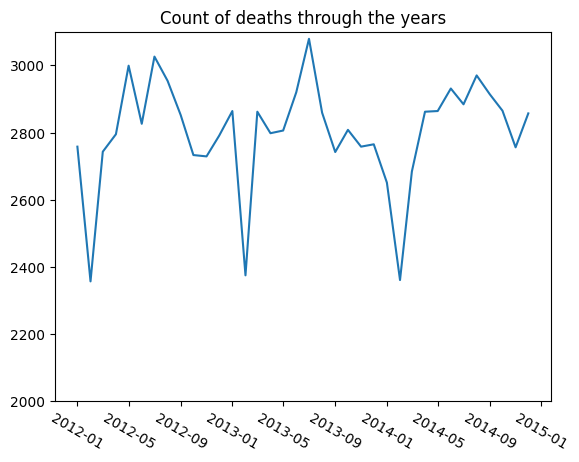

In [11]:
deaths_timeseries = df_clean.groupby('date')['id'].count()
plt.plot(df_clean['date'].unique(), deaths_timeseries)
plt.xticks(rotation=-30)
plt.ylim((2000, 3100))
plt.title('Count of deaths through the years')
plt.show()

### Summary of count of deaths through the years:
* 2013 has the most deaths, but there is not much difference between each year.
* The line graph depicts a dip in the count of deaths towards the start of each year.
* There is generally a higher count of deaths in the summer part of each year.

## Find distribution of intent.

In [12]:
sql_query = """
SELECT
    intent,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY intent
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,intent,count_deaths
0,Suicide,63176
1,Homicide,35176
2,Accidental,1639
3,Undetermined,807


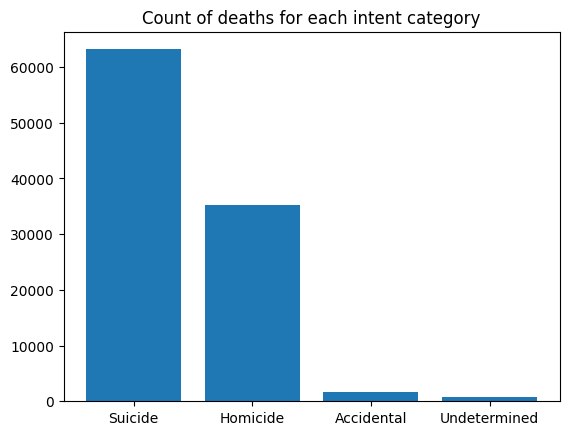

In [13]:
plt.bar(query_df['intent'], query_df['count_deaths'])
plt.title('Count of deaths for each intent category')
plt.show()

### Explore the racial disparities for each intent.

In [14]:
sql_query = """
SELECT
    race,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY race
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,race,count_deaths
0,White,66237
1,Black,23296
2,Hispanic,9022
3,Asian/Pacific Islander,1326
4,Native American/Native Alaskan,917


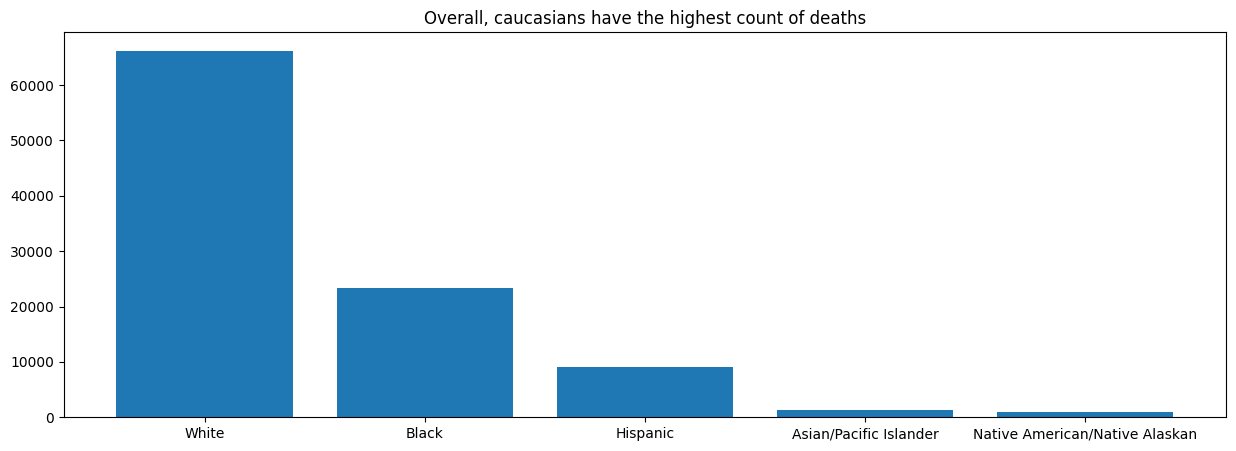

In [15]:
plt.figure(figsize=(15, 5))
plt.bar(query_df['race'], query_df['count_deaths'])
plt.title('Overall, caucasians have the highest count of deaths')
plt.show()

In [16]:
sql_query = """
SELECT
    race,
    COUNT(*) AS count_suicide_deaths
FROM dbo.gun_deaths
WHERE id IN (
    SELECT id FROM dbo.gun_deaths WHERE intent = 'Suicide'
)
GROUP BY race
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,race,count_suicide_deaths
0,White,55373
1,Black,3332
2,Hispanic,3171
3,Asian/Pacific Islander,745
4,Native American/Native Alaskan,555


In [17]:
sql_query = """
SELECT
    race,
    COUNT(*) AS count_homicide_deaths
FROM dbo.gun_deaths
WHERE id IN (
    SELECT id FROM dbo.gun_deaths WHERE intent = 'Homicide'
)
GROUP BY race
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,race,count_homicide_deaths
0,Black,19510
1,White,9147
2,Hispanic,5634
3,Asian/Pacific Islander,559
4,Native American/Native Alaskan,326


In [18]:
sql_query = """
SELECT
    race,
    COUNT(*) AS count_accidental_deaths
FROM dbo.gun_deaths
WHERE id IN (
    SELECT id FROM dbo.gun_deaths WHERE intent = 'Accidental'
)
GROUP BY race
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,race,count_accidental_deaths
0,White,1132
1,Black,328
2,Hispanic,145
3,Native American/Native Alaskan,22
4,Asian/Pacific Islander,12


In [19]:
sql_query = """
SELECT
    race,
    COUNT(*) AS count_undetermined_deaths
FROM dbo.gun_deaths
WHERE id IN (
    SELECT id FROM dbo.gun_deaths WHERE intent = 'Undetermined'
)
GROUP BY race
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,race,count_undetermined_deaths
0,White,585
1,Black,126
2,Hispanic,72
3,Native American/Native Alaskan,14
4,Asian/Pacific Islander,10


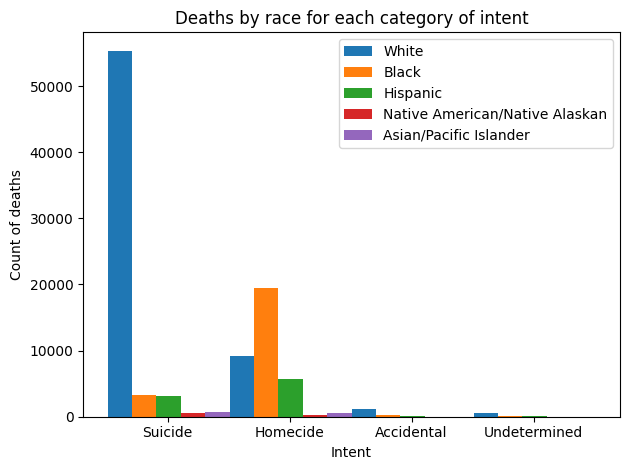

In [20]:
# Visualize with a grouped bar chart.
intents = ('Suicide', 'Homecide', 'Accidental', 'Undetermined')
death_counts = {
    'White': (55373, 9147, 1132, 585),
    'Black': (3332, 19510, 328, 126),
    'Hispanic': (3171, 5634, 145, 72),
    'Native American/Native Alaskan': (555, 326, 22, 14),
    'Asian/Pacific Islander': (745, 559, 12, 10)
}

fig, ax = plt.subplots()
bar_width = 0.2
x = np.arange(len(intents))
i = 0
for k, v in death_counts.items():
    ax.bar(x=x + bar_width * i, height=v, width=bar_width, label=k)
    i += 1

ax.set_xlabel('Intent')
ax.set_ylabel('Count of deaths')
ax.set_title('Deaths by race for each category of intent')
ax.set_xticks(x + 1.959 * bar_width)
ax.set_xticklabels(intents)
ax.legend()
plt.tight_layout()
plt.show()

* Caucasians account for most deaths in all intent categories except for homicide.
* Suicides from white people account for the most deaths in this dataset.
* Black people account for most deaths in the homicide category by far.

### Is there any correlation between where the death takes place and the intent?

In [63]:
sql_query = """
SELECT
    place,
    intent,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE place IN ('Home', 'Street')
GROUP BY place, intent
ORDER BY 1 ASC, 2 ASC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,place,intent,count_deaths
0,Home,Accidental,923
1,Home,Homicide,13613
2,Home,Suicide,45415
3,Home,Undetermined,535
4,Street,Accidental,78
5,Street,Homicide,8867
6,Street,Suicide,2181
7,Street,Undetermined,25


### From this table, we can tell that:
* The highest number of deaths inside homes are suicides.
* The highest number of deaths on the streets are homicides.

### Explore gender and education of the gun victims.

In [21]:
sql_query = """
SELECT
    sex,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY sex
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,sex,count_deaths
0,M,86349
1,F,14449


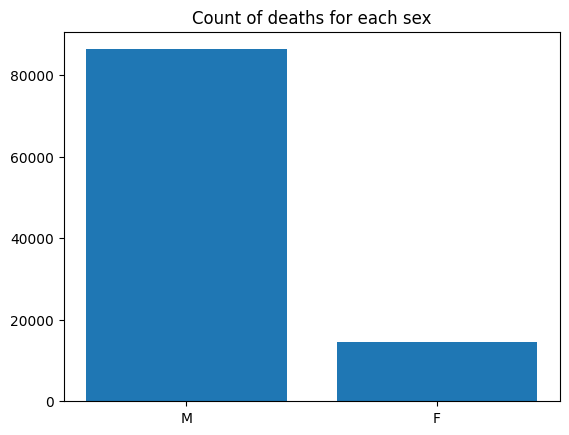

In [22]:
plt.bar(query_df['sex'], query_df['count_deaths'])
plt.title('Count of deaths for each sex')
plt.show()

* There are far more male victims than female victims.

In [23]:
sql_query = """
SELECT
    education,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY education
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,education,count_deaths
0,HS/GED,42927
1,Less than HS,21823
2,Some college,21680
3,BA+,12946
4,Other,1422


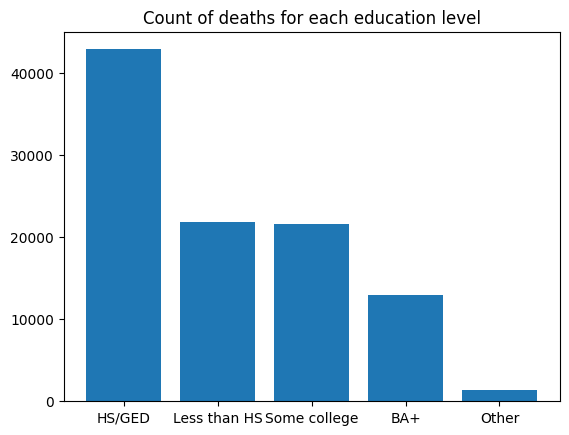

In [24]:
plt.bar(query_df['education'], query_df['count_deaths'])
plt.title('Count of deaths for each education level')
plt.show()

* Victims with high school level education account for most deaths

### Explore age of the victims

In [25]:
df_clean['age'].describe()

count    100798.000000
mean         43.857448
std          19.494443
min           0.000000
25%          27.000000
50%          42.000000
75%          58.000000
max         107.000000
Name: age, dtype: float64

In [26]:
print('Median: ' + str(df_clean['age'].median()))
print('Mode:   ' + str(df_clean['age'].mode()[0]))

Median: 42.0
Mode:   22


In [41]:
# Produce a table that categorizes the age ranges into minor(0-17), young adult(18-39), middle adult(40-64), and elderly(65+)
sql_query = """
SELECT 
    CASE WHEN age <= 17 THEN 'minor'
    WHEN age >= 18 AND age <= 39 THEN 'young adult'
    WHEN age >= 40 AND age <= 64 THEN 'middle adult'
    WHEN age >= 65 THEN 'elderly'
    END AS age_group,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY
    CASE WHEN age <= 17 THEN 'minor'
    WHEN age >= 18 AND age <= 39 THEN 'young adult'
    WHEN age >= 40 AND age <= 64 THEN 'middle adult'
    WHEN age >= 65 THEN 'elderly'
    END;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,age_group,count_deaths
0,young adult,43082
1,middle adult,37118
2,elderly,16708
3,minor,3890


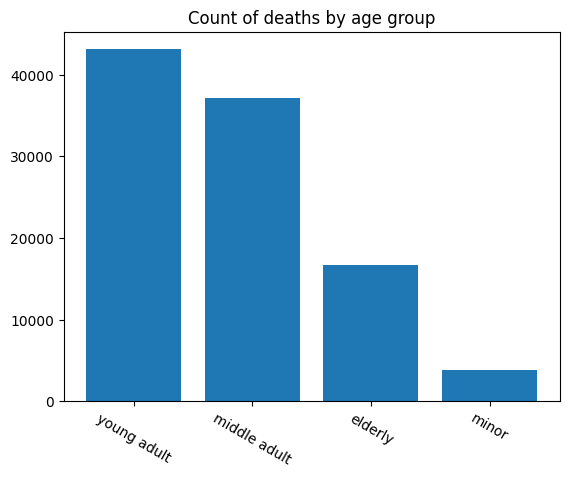

In [42]:
plt.bar(query_df['age_group'], query_df['count_deaths'])
plt.title('Count of deaths by age group')
plt.xticks(rotation=-30)
plt.show()

* Young adults (18-39) account for most gun-related deaths.
* Middle adults (40-64) make up the second highest deaths, though still far more deaths than elderly and minors.

In [54]:
# To visualize age groups in greater detail, lets create a histogram with the bin size to be about ten years.
sql_query = """
WITH bins_start AS (
    SELECT 
        ROW_NUMBER() OVER(ORDER BY value) as rownum,
        value
    FROM GENERATE_SERIES(0, 110, 10)
),
bins_stop AS (
    SELECT
        ROW_NUMBER() OVER(ORDER BY value) as rownum, 
        value
    FROM GENERATE_SERIES(9, 110, 10)
),
bins AS (
    SELECT
        a.value AS age_start_bin,
        b.value AS age_stop_bin
    FROM bins_start a
    JOIN bins_stop b ON a.rownum = b.rownum
)
SELECT 
    CASE WHEN b.age_start_bin = 0 THEN '0-9'
        WHEN b.age_start_bin = 10 THEN '10-19'
        WHEN b.age_start_bin = 20 THEN '20-29'
        WHEN b.age_start_bin = 30 THEN '30-39'
        WHEN b.age_start_bin = 40 THEN '40-49'
        WHEN b.age_start_bin = 50 THEN '50-59'
        WHEN b.age_start_bin = 60 THEN '60-69'
        WHEN b.age_start_bin = 70 THEN '70-79'
        WHEN b.age_start_bin = 80 THEN '80-89'
        WHEN b.age_start_bin = 90 THEN '90-99'
        WHEN b.age_start_bin = 100 THEN '100-109'
    END AS age_bin,
    COUNT(gd.age) AS count_deaths
FROM dbo.gun_deaths AS gd
JOIN bins AS b
    ON gd.age >= b.age_start_bin
    AND gd.age <= b.age_stop_bin
GROUP BY
    b.age_start_bin,
    b.age_stop_bin;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,age_bin,count_deaths
0,0-9,456
1,10-19,7252
2,20-29,22816
3,30-39,16448
4,40-49,15016
5,50-59,16169
6,60-69,10582
7,70-79,6822
8,80-89,4415
9,90-99,816


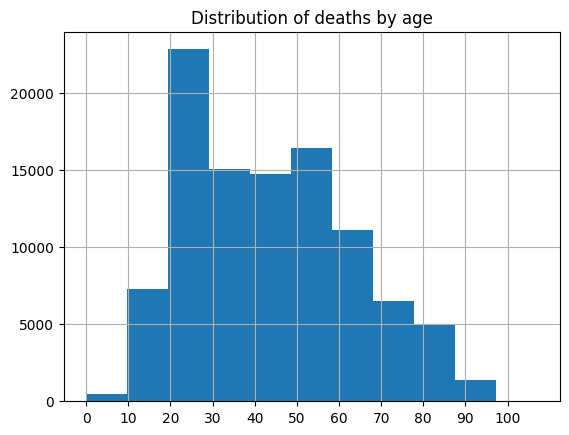

In [55]:
df_clean.hist(column='age', bins= 11)
plt.title('Distribution of deaths by age')
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

* Based off this histogram, the 20s age bin has the highest count of deaths by a lot.

### Lets explore the young adult age group (18-39) to extract further insights

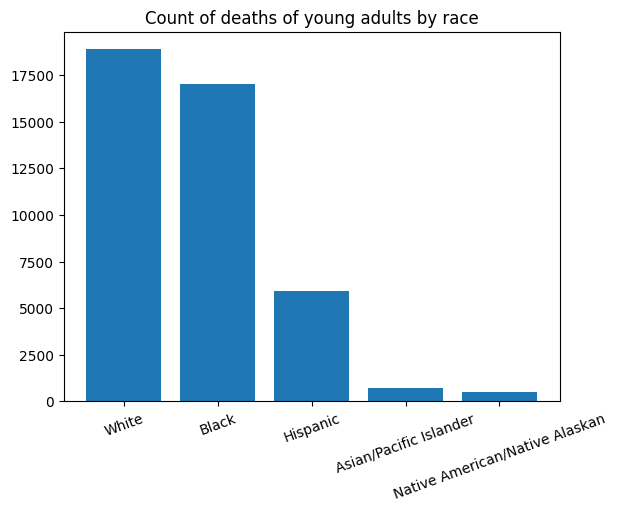

In [69]:
sql_query = """
SELECT
    race,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY race
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['race'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by race')
plt.xticks(rotation=20)
plt.show()

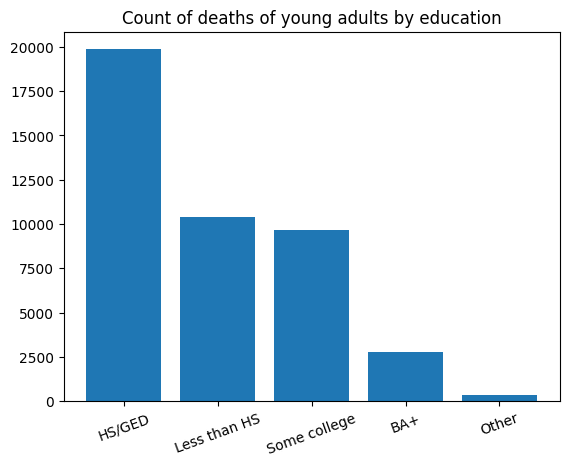

In [70]:
sql_query = """
SELECT
    education,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY education
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['education'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by education')
plt.xticks(rotation=20)
plt.show()

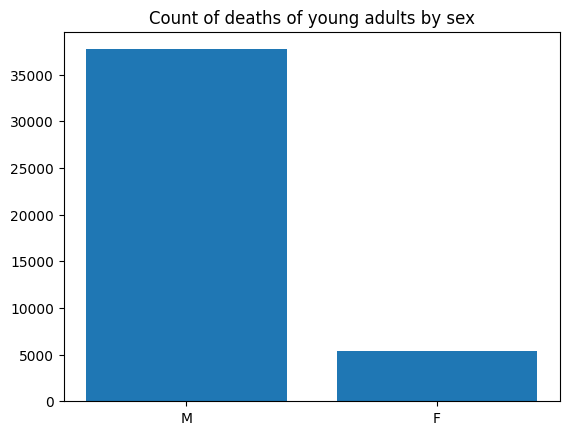

In [72]:
sql_query = """
SELECT
    sex,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY sex
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['sex'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by sex')
plt.show()

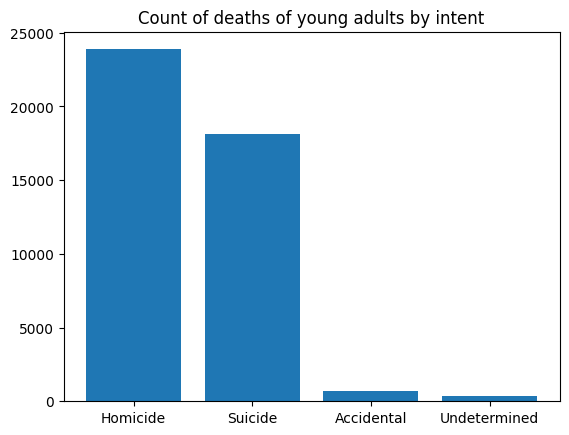

In [73]:
sql_query = """
SELECT
    intent,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY intent
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['intent'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by intent')
plt.show()

# Summary of findings
* Through the years, 2013 has the highest number of gun related deaths, though there is not a high number of difference between each year.
* White young adults account for most of the deaths in this dataset.
* Among the categories of intent, suicide has the highest count of deaths.
    * Within the suicide intent, white young adults make up most of the deaths.
    * Within the homicide intent, black young adults make up most of the deaths.
* There are far more male deaths than female deaths.
* Among the different age groups, young adults make up most of the deaths.